# Loop closure

### Boilerplate

In [1]:
%load_ext lab_black
# python internal
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
import random
import re
import socket
import shutil
import subprocess
import sys

# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from tqdm import tqdm

# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta

# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(os.getcwd())
print(socket.gethostname())

/mnt/home/pleung/projects/bistable_bundle/r4/hinges
dig130


### Flo's original approach:
4. now it gets even worse. I use`/home/flop/switch/5thround/DHRs/loops/score_to_loop.ipynb` to generate cmds for loop closure. have a look, and then we should probably talk about it. it is messy.
	
basically I first try to find loops that match the original DHR, for example
in: `/home/flop/switch/5thround/DHRs/loops/match_orig_d6_04/`

because this doesn't work for all of them, I also re-loop the original DHRs,
also sampling truncations and extensions of the helices before and after the
new loop

i exhaustively did that for all dhrs in my input set: 
`/home/flop/switch/5thround/DHRs/loops/x_ind_all_te`

then I try to find loops in the new states that match the outputs of the state
x relooping: `/home/flop/switch/5thround/DHRs/loops/match_ind_d6/`

### I will follow Flo's looping procedure with some changes.
I will use the serialization build of PyRosetta to enable recording user defined info about the designs.  
This enables downstream inline filtering and data analysis, as well as clustering by lineage.
I will try the following hierarchy of closure methods: 
1. close using identical length loop and no adjustment with connect chains mover (CCM) at 0.8 RMS (total length and SS match)
2. constrained remodel with `BluePrintBDR`, forcing SS agreement with parent but allowing any `ABEGO` (total length and SS match)
These methods seem to get around 75% closure, which I think will be pretty workable.  


Things that aren't at the moment worthwhile:
1. close using identical length loop and +/-2 res adjustment on each side with CCM at 0.4 RMS (total length match, potential SS mismatch)  
This one has issues with the adjustments resulting in unexpected lengths of the finished design 
2. less constrained remodel with `BluePrintBDR`, allowing any secondary structure and any `ABEGO` (total length match, potential SS mismatch)  
This one doesn't seem like it would get significantly more closures, for approximately 40% more compute
3. Dmitri Zorine's brand new enumerative method
Would like to try this at some point in the future though

### Make functions for looping and labeling to assist downstream penultimate design step

In [2]:
from pyrosetta.distributed.packed_pose.core import PackedPose
from pyrosetta.distributed import requires_init
from typing import *


@requires_init
def loop_match(packed_pose_in: PackedPose, **kwargs) -> PackedPose:
    """
    Match loop length, total length and DSSP with parent. Strictest method of closure.
    """
    import bz2
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        SingleoutputRosettaScriptsTask,
    )

    if packed_pose_in == None:
        file = kwargs["-s"]
        with open(file, "rb") as f:
            packed_pose_in = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
        scores = pyrosetta.distributed.cluster.get_scores_dict(file)["scores"]
    else:
        raise RuntimeError("Need to supply an input")
    # get parent from packed_pose_in, get loop length from parent length - packed_pose_in length
    parent_length = int(scores["parent_length"])
    length = int(parent_length - len(packed_pose_in.pose.residues))
    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="beta_nov16" /> 
        </SCOREFXNS>
        <RESIDUE_SELECTORS>          
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
        </TASKOPERATIONS>
        <SIMPLE_METRICS>
        </SIMPLE_METRICS>
        <MOVERS>
            <ConnectChainsMover name="closer" 
                chain_connections="[A+B]" 
                loopLengthRange="{length},{length}" 
                resAdjustmentRangeSide1="0,0" 
                resAdjustmentRangeSide2="0,0" 
                RMSthreshold="1.0"/>
            <SwitchChainOrder name="rechain" chain_order="1"/>
        </MOVERS>
        <FILTERS>
        </FILTERS>
        <PROTOCOLS>
            <Add mover_name="closer"/>
            <Add mover_name="rechain"/>
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """.format(
        length=length
    )
    closer = SingleoutputRosettaScriptsTask(xml)
    try:
        maybe_closed_ppose = closer(packed_pose_in.pose.clone())
        maybe_closed_pose = io.to_pose(maybe_closed_ppose)
        closure_type = "loop_match"
    except RuntimeError:
        maybe_closed_pose = io.to_pose(packed_pose_in.pose.clone())
        closure_type = "not_closed"
    pyrosetta.rosetta.core.pose.setPoseExtraScore(
        maybe_closed_pose, "closure_type", closure_type
    )
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(
            maybe_closed_pose, key, str(value)
        )
    final_ppose = io.to_packed(maybe_closed_pose)
    return final_ppose


def strict_remodel(packed_pose_in: PackedPose, **kwargs) -> PackedPose:
    """
    DSSP and SS agnostic in principle but in practice more or less matches.
    """
    import os
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.packed_pose.core import PackedPose
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        SingleoutputRosettaScriptsTask,
    )

    def strict_remodel_helper(packed_pose_in: PackedPose, loop_length: int) -> str:
        import binascii, os
        import pyrosetta
        from pyrosetta.rosetta.core.pose import Pose

        def phi_psi_omega_to_abego(phi: float, psi: float, omega: float) -> str:
            """
            From Buwei
            https://wiki.ipd.uw.edu/protocols/dry_lab/rosetta/scaffold_generation_with_piecewise_blueprint_builder
            """
            if psi == None or phi == None:
                return "X"
            if omega == None:
                omega = 180

            if abs(omega) < 90:
                return "O"
            elif phi > 0:
                if -100.0 <= psi < 100:
                    return "G"
                else:
                    return "E"
            else:
                if -75.0 <= psi < 50:
                    return "A"
                else:
                    return "B"
            return "X"

        def abego_string(phi_psi_omega: list) -> str:
            """
            From Buwei
            https://wiki.ipd.uw.edu/protocols/dry_lab/rosetta/scaffold_generation_with_piecewise_blueprint_builder
            """
            out = ""
            for x in phi_psi_omega:
                out += phi_psi_omega_to_abego(x[0], x[1], x[2])
            return out

        def get_torsions(pose: Pose) -> list:
            """
            From Buwei
            https://wiki.ipd.uw.edu/protocols/dry_lab/rosetta/scaffold_generation_with_piecewise_blueprint_builder
            """
            torsions = []
            for i in range(1, pose.total_residue() + 1):
                phi = pose.phi(i)
                psi = pose.psi(i)
                omega = pose.omega(i)
                if i == 1:
                    phi = None
                if i == pose.total_residue():
                    psi = None
                    omega = None
                torsions.append((phi, psi, omega))
            return torsions

        pose = packed_pose_in.pose.clone()
        tors = get_torsions(pose)
        abego_str = abego_string(tors)
        dssp = pyrosetta.rosetta.protocols.simple_filters.dssp(pose)
        # name blueprint a random 32 long hex string
        filename = str(binascii.b2a_hex(os.urandom(16)).decode("utf-8")) + ".bp"
        # write a temporary blueprint file
        with open(filename, "w+") as f:
            end1, begin2 = (
                packed_pose_in.pose.chain_end(1),
                packed_pose_in.pose.chain_begin(2),
            )
            end2 = packed_pose_in.pose.chain_end(2)
            for i in range(1, end1 + 1):
                if i == end1:
                    print(
                        str(i),
                        packed_pose_in.pose.residue(i).name1(),
                        dssp[i - 1] + "X",
                        "R",
                        file=f,
                    )
                else:
                    print(
                        str(i),
                        packed_pose_in.pose.residue(i).name1(),
                        dssp[i - 1] + abego_str[i - 1],
                        ".",
                        file=f,
                    )
            for i in range(loop_length):
                print(
                    "0", "V", "LX", "R", file=f
                )  # TODO DX is bad, causes rare error sometimes
            for i in range(begin2, end2 + 1):
                if i == begin2:
                    print(
                        str(i),
                        packed_pose_in.pose.residue(i).name1(),
                        dssp[i - 1] + "X",
                        "R",
                        file=f,
                    )
                else:
                    print(
                        str(i),
                        packed_pose_in.pose.residue(i).name1(),
                        dssp[i - 1] + abego_str[i - 1],
                        ".",
                        file=f,
                    )
        return filename

    # ensure pose still needs to be closed
    if packed_pose_in.pose.num_chains() == 1:
        final_ppose = io.to_packed(packed_pose_in.pose.clone())
        return final_ppose
    else:
        scores = packed_pose_in.pose.scores
        # get parent from packed_pose_in, get loop length from parent length - packed_pose_in length
        parent_length = int(scores["parent_length"])
        length = int(parent_length - len(packed_pose_in.pose.residues))
        bp = strict_remodel_helper(packed_pose_in, length)
        xml = """
        <ROSETTASCRIPTS>
            <SCOREFXNS>
                <ScoreFunction name="sfxn1" weights="fldsgn_cen">
                    <Reweight scoretype="hbond_sr_bb" weight="1.0" />
                    <Reweight scoretype="hbond_lr_bb" weight="1.0" />
                    <Reweight scoretype="atom_pair_constraint" weight="1.0" />
                    <Reweight scoretype="angle_constraint" weight="1.0" />
                    <Reweight scoretype="dihedral_constraint" weight="1.0" />
                </ScoreFunction>
            </SCOREFXNS>
            <RESIDUE_SELECTORS>          
            </RESIDUE_SELECTORS>
            <TASKOPERATIONS>
            </TASKOPERATIONS>
            <SIMPLE_METRICS>
            </SIMPLE_METRICS>
            <MOVERS>
                <BluePrintBDR name="bdr" 
                blueprint="{bp}" 
                use_abego_bias="0" 
                use_sequence_bias="0" 
                rmdl_attempts="20"
                scorefxn="sfxn1"/>
            </MOVERS>
            <FILTERS>
            </FILTERS>
            <PROTOCOLS>
                <Add mover_name="bdr"/>
            </PROTOCOLS>
        </ROSETTASCRIPTS>
        """.format(
            bp=bp
        )
        strict_remodel = SingleoutputRosettaScriptsTask(xml)
        maybe_closed_ppose = None
        for i in range(10):
            print(f"attempt: {i}")
            if maybe_closed_ppose is not None:  # check if it worked
                break  # stop retrying if it did
            else:  # try again if it didn't. returns None if fail
                maybe_closed_ppose = strict_remodel(packed_pose_in.pose.clone())
        os.remove(bp)  # cleanup tree
        if maybe_closed_ppose is not None:
            closure_type = "strict_remodel"
            maybe_closed_pose = io.to_pose(maybe_closed_ppose)
            for key, value in scores.items():
                pyrosetta.rosetta.core.pose.setPoseExtraScore(
                    maybe_closed_pose, key, str(value)
                )
            # update closure_type
            pyrosetta.rosetta.core.pose.setPoseExtraScore(
                maybe_closed_pose, "closure_type", closure_type
            )
            final_ppose = io.to_packed(maybe_closed_pose)
        else:  # return the original input if BlueprintBDR still didn't close
            final_ppose = io.to_packed(packed_pose_in.pose.clone())
        return final_ppose


def label(packed_pose_in: PackedPose, **kwargs) -> PackedPose:
    """
    Label poly valine
    """
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        SingleoutputRosettaScriptsTask,
    )
    from pyrosetta.rosetta.core.pose import Pose
    from pyrosetta.rosetta.core.select import get_residues_from_subset
    from pyrosetta.rosetta.protocols.rosetta_scripts import XmlObjects

    def phi_psi_omega_to_abego(phi: float, psi: float, omega: float) -> str:
        """
        From Buwei
        https://wiki.ipd.uw.edu/protocols/dry_lab/rosetta/scaffold_generation_with_piecewise_blueprint_builder
        """
        if psi == None or phi == None:
            return "X"
        if omega == None:
            omega = 180

        if abs(omega) < 90:
            return "O"
        elif phi > 0:
            if -100.0 <= psi < 100:
                return "G"
            else:
                return "E"
        else:
            if -75.0 <= psi < 50:
                return "A"
            else:
                return "B"
        return "X"

    def abego_string(phi_psi_omega: list) -> str:
        """
        From Buwei
        https://wiki.ipd.uw.edu/protocols/dry_lab/rosetta/scaffold_generation_with_piecewise_blueprint_builder
        """
        out = ""
        for x in phi_psi_omega:
            out += phi_psi_omega_to_abego(x[0], x[1], x[2])
        return out

    def get_torsions(pose: Pose) -> list:
        """
        From Buwei
        https://wiki.ipd.uw.edu/protocols/dry_lab/rosetta/scaffold_generation_with_piecewise_blueprint_builder
        """
        torsions = []
        for i in range(1, pose.total_residue() + 1):
            phi = pose.phi(i)
            psi = pose.psi(i)
            omega = pose.omega(i)
            if i == 1:
                phi = None
            if i == pose.total_residue():
                psi = None
                omega = None
            torsions.append((phi, psi, omega))
        return torsions

    def find_vv(seq):
        indices = []
        seq_minus_one = seq[:-1]
        for i, char in enumerate(seq_minus_one):
            if (char == seq[i + 1]) and (char == "V"):
                indices.append(i + 1)
            else:
                pass
        # rosetta sequence indexes begin at 1
        true_indices = [str(x + 1) for x in indices]
        return true_indices

    scores = packed_pose_in.pose.scores
    if (
        packed_pose_in.pose.num_chains() != 1
    ):  # ensure pose has been closed, if not don't label
        new_loop_str = "0,0"
        labeled_pose = packed_pose_in.pose.clone()
    else:
        seq = str(packed_pose_in.pose.sequence())
        vv_indices = ",".join(find_vv(seq))
        pivot_helix = int(scores["pivot_helix"])
        pre_break_helix = int(scores["pre_break_helix"])
        # get helix indices for the pre and post break helices
        lower = pre_break_helix
        upper = pre_break_helix + 1
        xml = """
        <ROSETTASCRIPTS>
            <SCOREFXNS>
                <ScoreFunction name="sfxn" weights="beta_nov16" /> 
            </SCOREFXNS>
            <RESIDUE_SELECTORS>
                <SSElement name="middle" selection="{lower},H,E" to_selection="{upper},H,S" chain="A" reassign_short_terminal_loop="2" />
                <Index name="polyval_all" resnums="{vv_indices}" />
                <And name="polyval" selectors="middle,polyval_all" />
                <PrimarySequenceNeighborhood name="entire_val" selector="polyval" lower="5" upper="5" />
                <SecondaryStructure name="loop" overlap="0" minH="3" minE="2" include_terminal_loops="true" use_dssp="true" ss="L"/>
                <And name="new_loop_center" selectors="entire_val,loop" />
                <PrimarySequenceNeighborhood name="entire_new_loop_broad" selector="new_loop_center" lower="5" upper="5" />
                <ResidueName name="isval" residue_name3="VAL" />
                <And name="entire_new_loop" selectors="entire_new_loop_broad,isval" />
            </RESIDUE_SELECTORS>
            <TASKOPERATIONS>
            </TASKOPERATIONS>
            <SIMPLE_METRICS>
            </SIMPLE_METRICS>
            <MOVERS>
                <AddResidueLabel name="add_loop_label" residue_selector="entire_new_loop" label="new_loop" />  
            </MOVERS>
            <FILTERS>
            </FILTERS>
            <PROTOCOLS>
                <Add mover="add_loop_label" />
            </PROTOCOLS>
        </ROSETTASCRIPTS>
        """.format(
            lower=lower, upper=upper, vv_indices=vv_indices
        )
        labeled = SingleoutputRosettaScriptsTask(xml)
        xml_obj = XmlObjects.create_from_string(xml)
        entire_new_loop_sel = xml_obj.get_residue_selector("entire_new_loop")
        labeled_ppose = labeled(packed_pose_in.pose.clone())
        labeled_pose = io.to_pose(labeled_ppose)
        new_loop_resis = list(
            get_residues_from_subset(entire_new_loop_sel.apply(labeled_pose))
        )
        new_loop_str = ",".join(str(resi) for resi in new_loop_resis)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(
        labeled_pose, "new_loop_resis", new_loop_str
    )
    total_length = len(labeled_pose.residues)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(
        labeled_pose, "total_length", total_length
    )
    dssp = pyrosetta.rosetta.protocols.simple_filters.dssp(labeled_pose)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(labeled_pose, "dssp", dssp)
    tors = get_torsions(labeled_pose)
    abego_str = abego_string(tors)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(labeled_pose, "abego_str", abego_str)
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(labeled_pose, key, str(value))
    final_ppose = io.to_packed(labeled_pose)
    return final_ppose

### Setup dask, set command line options, make tasks and submit to client
At some point I should try using `client.wait_for_workers(n_workers=1, timeout=None)`

In [4]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import logging
import pwd
from pyrosetta.distributed.cluster.core import PyRosettaCluster


print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)


def create_tasks(selected, options):
    with open(selected, "r") as f:
        for file in f:
            tasks = {"options": "-corrections::beta_nov16 true"}
            tasks["extra_options"] = options
            tasks["-s"] = file.rstrip()
            tasks["sfxn"] = "beta_nov16"
            yield tasks


logging.basicConfig(level=logging.INFO)
selected = os.path.join(os.getcwd(), "02_design_score/not_bad.list")

options = {
    "-out:level": "300",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
}

output_path = os.path.join(os.getcwd(), "03_enumerate_loops")

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="6GB",
        queue="medium",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "23h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-1020 workers,
        cluster.adapt(
            minimum=1,
            maximum=1020,
            wait_count=999,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            PyRosettaCluster(
                tasks=create_tasks(selected, options),
                client=client,
                scratch_dir=output_path,
                output_path=output_path,
            ).distribute(protocols=[loop_match, strict_remodel, label])

run the following from your local terminal:
ssh -L 8000:localhost:8787 pleung@dig112
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=6G
#SBATCH -t 23:30:00

JOB_ID=${SLURM_JOB_ID%;*}

/home/pleung/.conda/envs/phil/bin/python -m distributed.cli.dask_worker tcp://172.16.131.216:34281 --nthreads 1 --memory-limit 5.59GiB --name name --nanny --death-timeout 120 --local-directory $TMPDIR/dask --lifetime 23h --lifetime-stagger 4m

<Client: 'tcp://172.16.131.216:34281' processes=0 threads=0, memory=0 B>


INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/phil/lib/python3.8/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.12+release.ed6a5560506cfd327d4a6a3e2c9b0c9f6f4a6535 2021-03-26T16:09:25] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


### Look at scores
Hacky function to load JSON-like data

In [2]:
def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores


output_path = os.path.join(os.getcwd(), "03_enumerate_loops")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

,abego_str,bb_clash,closure_type,dssp,interface_buried_sasa,new_loop_resis,parent,parent_length,pivot_helix,pre_break_helix,...,lk_ball,lk_ball_bridge,lk_ball_bridge_uncpl,lk_ball_iso,omega,p_aa_pp,pro_close,rama_prepro,ref,total_score
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/03_enumerate_loops/decoys/0000/2021.05.02.23.34.18.110963_2a6f8cf3bae94e6f94534bc14d0bed0a.pdb.bz2,XAAAAAAAAAAAAAAAAAAAAAAGBBAAAAAAAAAAAAAAAAAAAA...,89.63912963867188,strict_remodel,LHHHHHHHHHHHHHHHHHHHHHHLLLHHHHHHHHHHHHHHHHHHHH...,1652.7481689453125,"149,150,151,152",THR11,304,6,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/03_enumerate_loops/decoys/0000/2021.05.02.23.34.18.110963_d0ebbad7002c46bfad8ebf47a42f771c.pdb.bz2,XAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBBAAAA...,45.20452117919922,loop_match,LHHHHHHHHHHHHHHHHHHLLHHHHHHHHHHHHHHHHHHLLLHHHH...,1786.3101806640625,"77,82,83,84",DHR07_nocys,168,5,4,...,487.224482,2.694334,17.186658,1190.581348,31.794270,-41.255857,1.113450,25.102051,1.162654,1612.047722
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/03_enumerate_loops/decoys/0000/2021.05.02.23.34.18.110963_5e3e1aee9f0341778f4a489b7afccd74.pdb.bz2,XAAAAAAAAAAAAAAAAAAAABBAAAAAAAAAAAAAAAAAAAAAAA...,51.77362823486328,loop_match,LHHHHHHHHHHHHHHHHHHHHLLHHHHHHHHHHHHHHHHHHHHHHH...,1681.164794921875,"95,99,100,101,102,107",TH_DHR_DN-T6,201,5,4,...,551.189029,3.687640,27.051500,1368.291098,145.454600,-65.343508,0.237962,61.566349,0.997786,2658.428334
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/03_enumerate_loops/decoys/0000/2021.05.02.23.34.18.110963_3f4aa29204234889a6dc9b925287d80b.pdb.bz2,XAAAAAAAAAAAAAAABBGBAAAAAAAAAAAAAAABABAAAAAAAA...,36.63492965698242,strict_remodel,LHHHHHHHHHHHHHHHLLLLHHHHHHHHHHHHHHHLLLHHHHHHHH...,1892.1275634765625,"72,74,75,76",DHR21,152,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/03_enumerate_loops/decoys/0000/2021.05.02.23.34.18.110963_c5c1936cac57499888d06fd30b9d1ab4.pdb.bz2,XAAAAAAAAAAAAAAAAABBGBAAAAAAAAAAAAAAAAAABBGBAA...,48.391422271728516,loop_match,LHHHHHHHHHHHHHHHHHLLLLHHHHHHHHHHHHHHHHHHLLLLHH...,1861.9246826171875,"82,83,85,86,87,88,92",DHR01_nocys,176,4,4,...,472.847875,2.807448,17.883739,1161.380661,24.320869,-62.193773,0.328207,94.480159,14.406524,2156.150235


In [3]:
len(scores_df)

3734

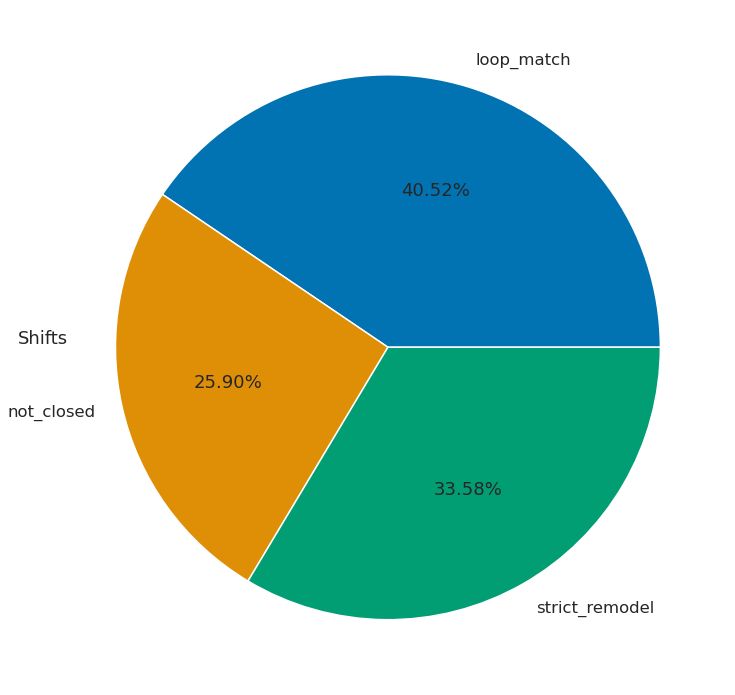

In [4]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)
(
    fig,
    ax1,
) = plt.subplots(ncols=1, figsize=(20, 10), tight_layout=True)
scores_df.groupby("closure_type").size().plot(kind="pie", autopct="%1.2f%%", ax=ax1)
ax1.set_ylabel("Shifts", rotation=0)
plt.savefig("figs/03_closure_types.png")

### What metadata predicts looping failures

In [5]:
scores_df.columns

Index(['abego_str', 'bb_clash', 'closure_type', 'dssp',
       'interface_buried_sasa', 'new_loop_resis', 'parent', 'parent_length',
       'pivot_helix', 'pre_break_helix', 'sc', 'sc_int', 'score_A', 'score_B',
       'score_per_res', 'sfxn_used', 'shift', 'total_length', 'dslf_fa13',
       'fa_atr', 'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi', 'fa_elec',
       'fa_intra_atr_xover4', 'fa_intra_elec', 'fa_intra_rep_xover4',
       'fa_intra_sol_xover4', 'fa_rep', 'fa_sol', 'hbond_bb_sc', 'hbond_lr_bb',
       'hbond_sc', 'hbond_sr_bb', 'hxl_tors', 'lk_ball', 'lk_ball_bridge',
       'lk_ball_bridge_uncpl', 'lk_ball_iso', 'omega', 'p_aa_pp', 'pro_close',
       'rama_prepro', 'ref', 'total_score'],
      dtype='object')

In [6]:
def parent2scaffold(row):
    parent = row["parent"]
    if "THR" in parent:
        scaffold = "THR"
    elif "TH_DHR" in parent:
        scaffold = "TH_DHR"
    elif "KH_" in parent:
        scaffold = "KH_DHR"
    elif "hDHR" in parent:
        scaffold = "hDHR"
    elif "DHR" in parent:
        scaffold = "DHR"
    else:
        raise RuntimeError
    return scaffold


scores_df["scaffold"] = scores_df.apply(parent2scaffold, axis=1)
scores_df.groupby(["scaffold"]).mean()

,total_length,dslf_fa13,fa_atr,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,fa_intra_rep_xover4,...,lk_ball,lk_ball_bridge,lk_ball_bridge_uncpl,lk_ball_iso,omega,p_aa_pp,pro_close,rama_prepro,ref,total_score
scaffold,,,,,,,,,,,,,,,,,,,,,
DHR,192.107368,0.0,-1229.111229,177.448589,168.422827,223.621586,-424.116100,-70.683324,-40.357464,122.279757,...,594.193020,2.621822,19.540182,1409.177374,63.811452,-64.174055,12.291054,33.088984,-51.431891,1771.884309
KH_DHR,191.260870,0.0,-1148.613853,225.297816,148.136980,248.448087,-390.512081,-70.692433,-44.593227,126.351693,...,530.265254,3.845753,27.209187,1315.211464,53.825114,-66.060869,0.391800,31.489193,-36.248622,1900.603329
THR,341.936118,0.0,-2158.082577,221.692917,283.279515,385.526317,-702.590788,-131.512865,-64.460651,207.302953,...,969.094200,7.228680,53.244981,2358.454761,75.718635,-104.485100,6.398993,101.998793,-78.876142,1607.909376
TH_DHR,229.026398,0.0,-1412.243615,189.323544,188.267918,246.614814,-479.669421,-81.033266,-54.808005,149.556717,...,664.210963,4.195498,30.233476,1594.385046,56.865494,-75.185398,13.800293,16.936263,2.771556,1697.387659
hDHR,190.142429,0.0,-1166.250881,177.424997,161.068645,216.085621,-395.139214,-69.582459,-46.214676,122.578395,...,553.093407,3.349324,24.919549,1335.549993,54.191555,-59.450994,13.532275,30.651892,-49.939915,1692.199760


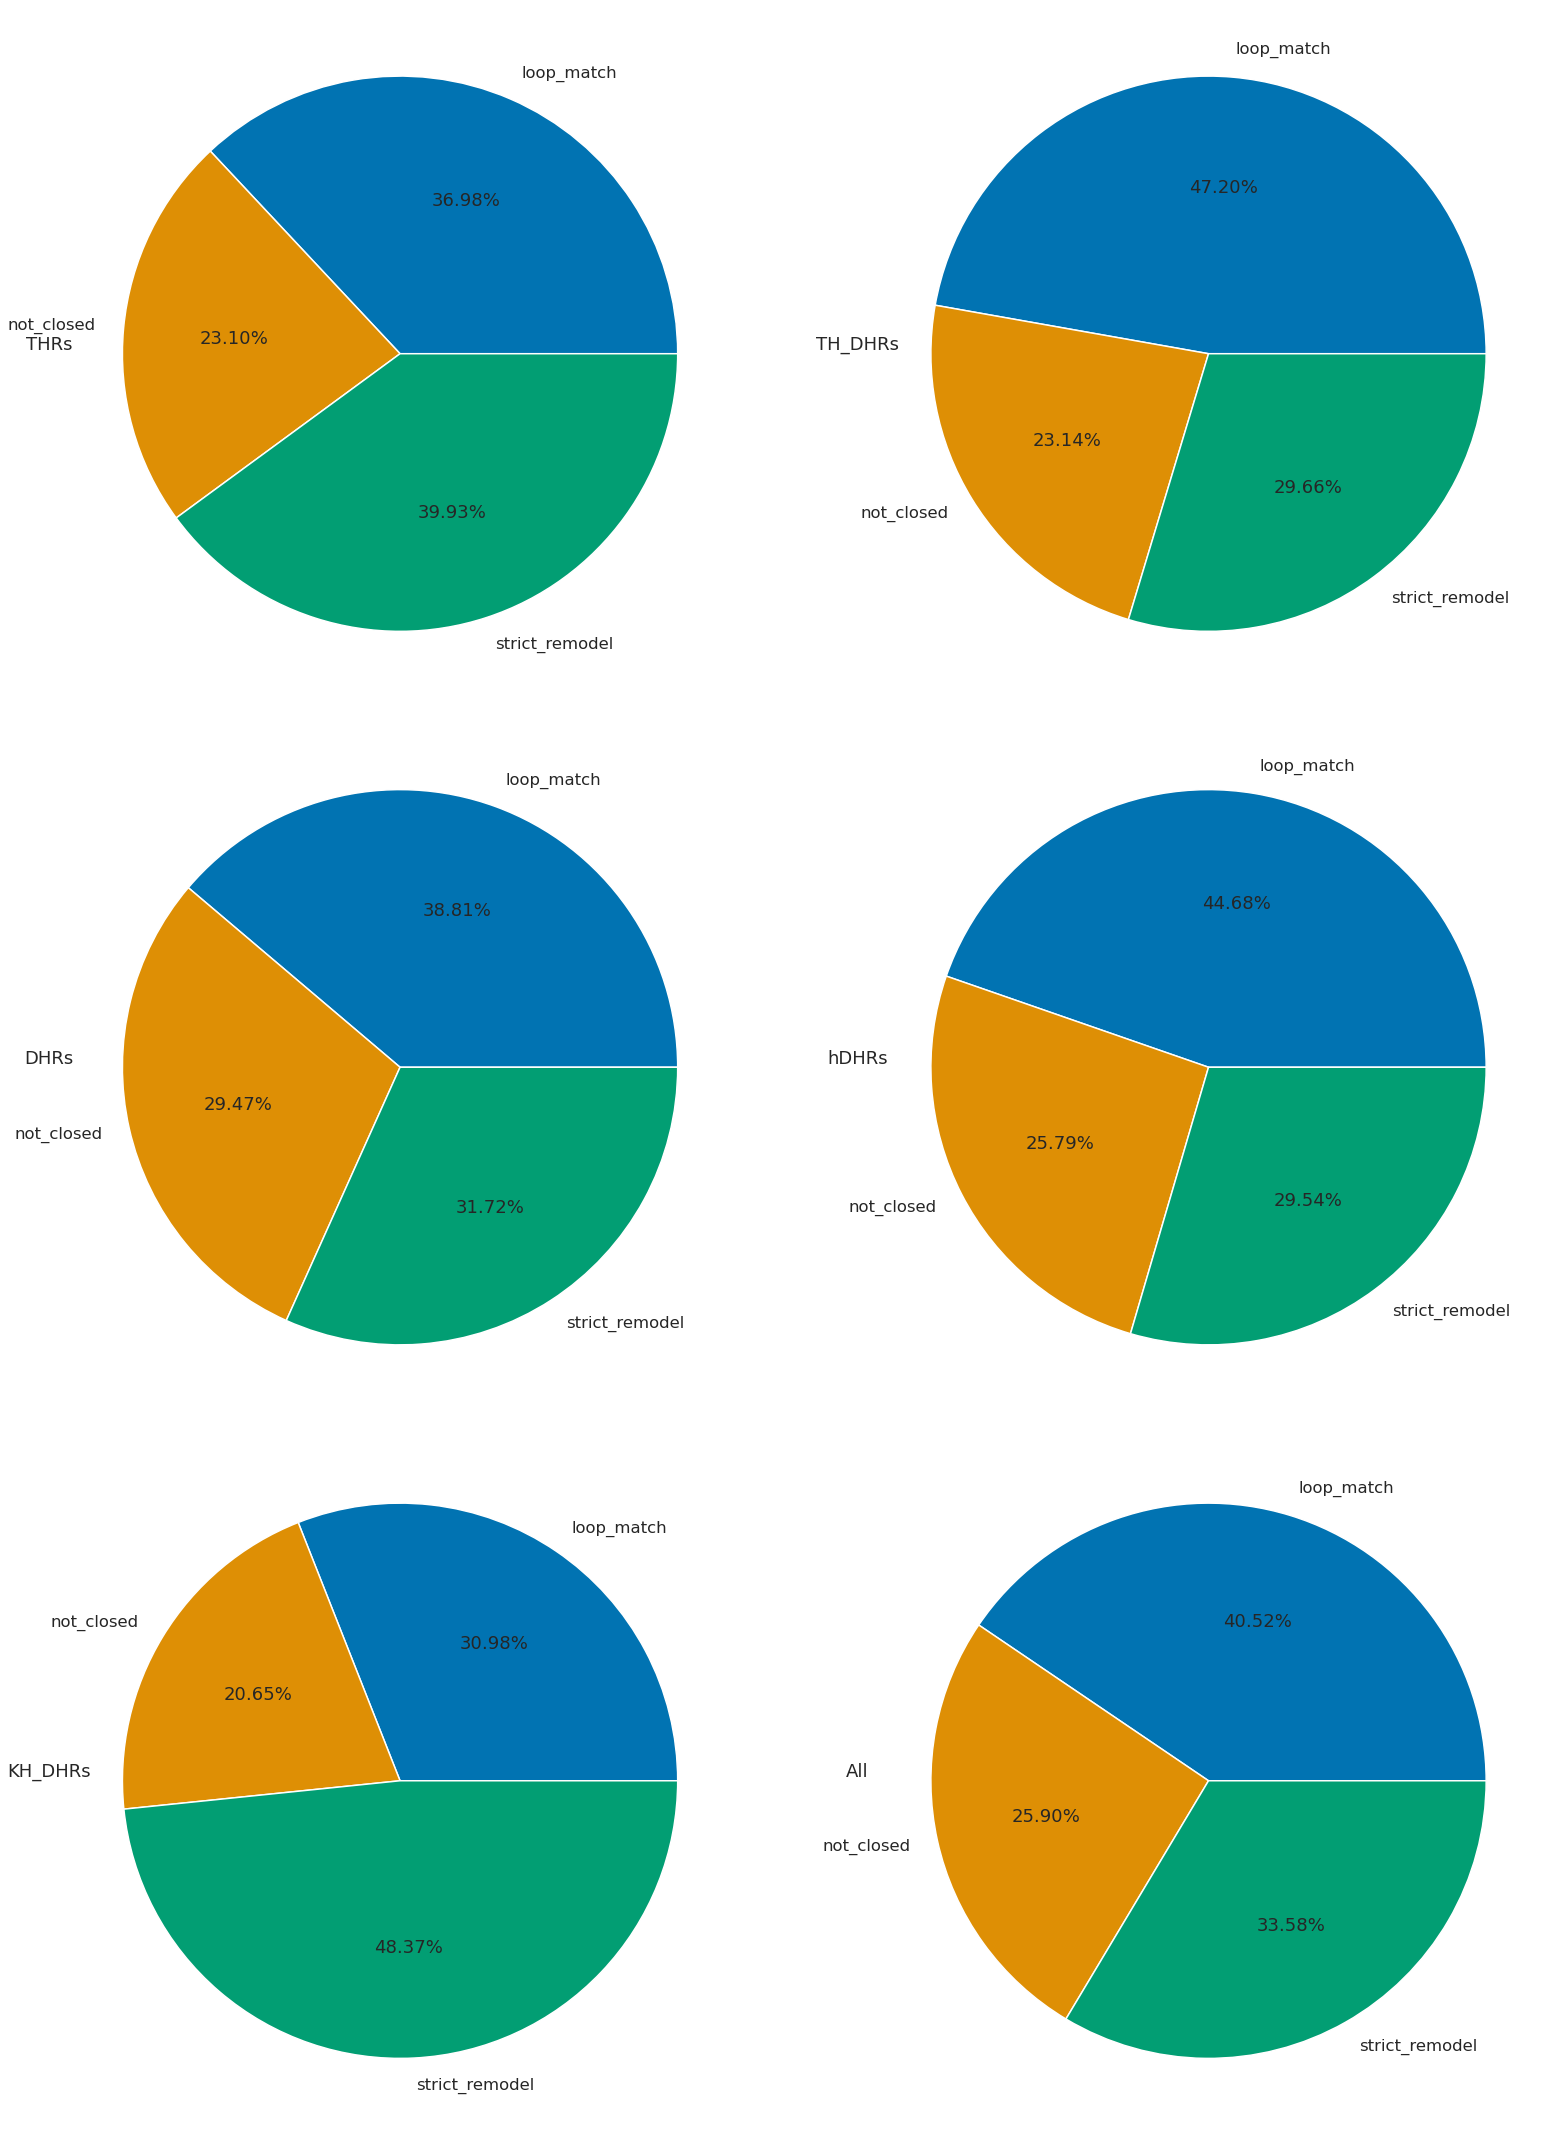

In [7]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
    ncols=2, nrows=3, figsize=(30, 30), tight_layout=True
)
scores_df[scores_df["scaffold"] == "THR"].groupby("closure_type").size().plot(
    kind="pie", autopct="%1.2f%%", ax=ax1
)
scores_df[scores_df["scaffold"] == "TH_DHR"].groupby("closure_type").size().plot(
    kind="pie", autopct="%1.2f%%", ax=ax2
)
scores_df[scores_df["scaffold"] == "DHR"].groupby("closure_type").size().plot(
    kind="pie", autopct="%1.2f%%", ax=ax3
)
scores_df[scores_df["scaffold"] == "hDHR"].groupby("closure_type").size().plot(
    kind="pie", autopct="%1.2f%%", ax=ax4
)
scores_df[scores_df["scaffold"] == "KH_DHR"].groupby("closure_type").size().plot(
    kind="pie", autopct="%1.2f%%", ax=ax5
)
scores_df.groupby("closure_type").size().plot(kind="pie", autopct="%1.2f%%", ax=ax6)
ax1.set_ylabel("THRs", rotation=0)
ax2.set_ylabel("TH_DHRs", rotation=0)
ax3.set_ylabel("DHRs", rotation=0)
ax4.set_ylabel("hDHRs", rotation=0)
ax5.set_ylabel("KH_DHRs", rotation=0)
ax6.set_ylabel("All", rotation=0)
plt.savefig("figs/03_looping_counts_by_scaffold.png")

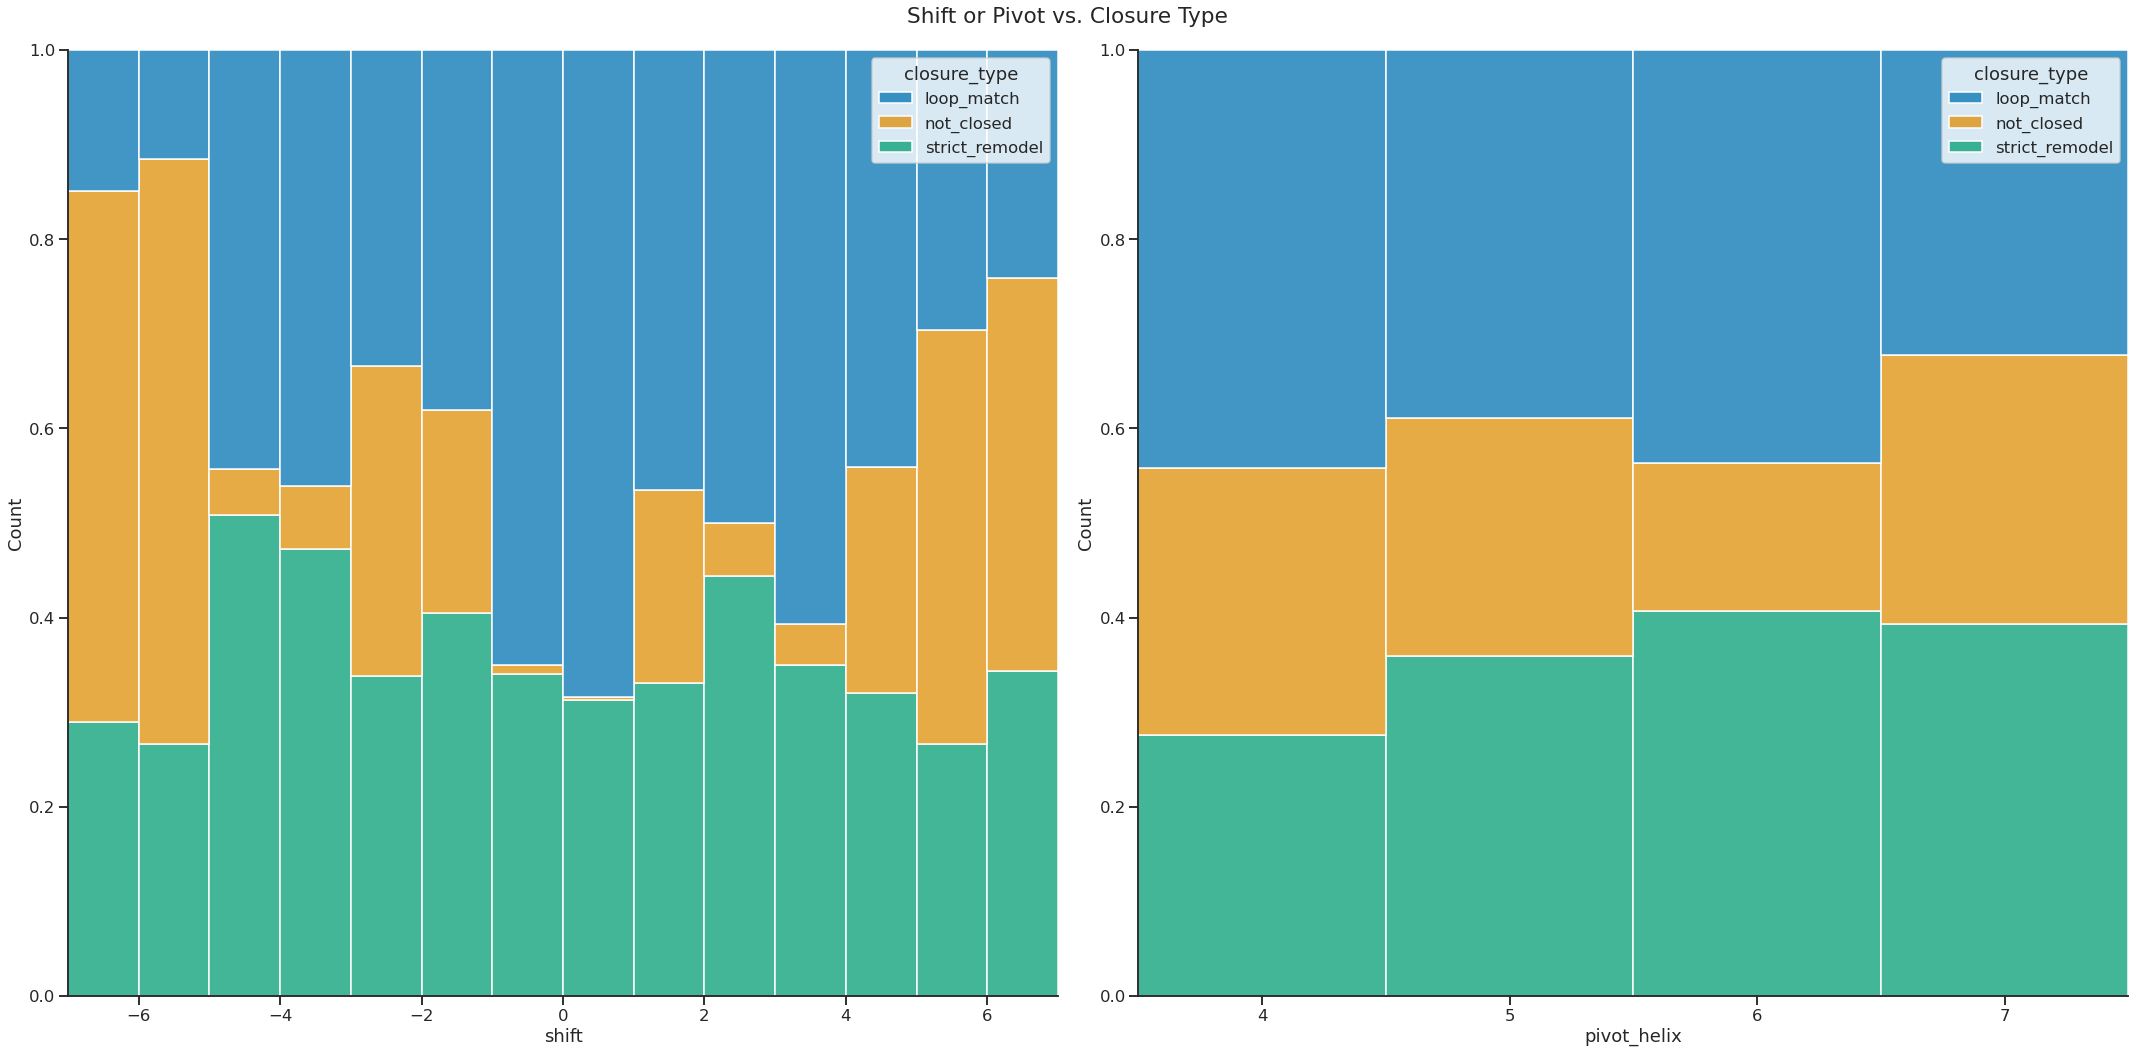

In [8]:
hue_order = ["loop_match", "not_closed", "strict_remodel"]  # for consistency with above

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(30, 15), tight_layout=True)

temp_df = scores_df.copy()
temp_df["shift"] = temp_df["shift"].astype(int)

sns.histplot(
    x="shift",
    data=temp_df.sort_values(["shift"]),
    ax=ax1,
    hue="closure_type",
    hue_order=hue_order,
    multiple="fill",
)

sns.histplot(
    x="pivot_helix",
    data=scores_df.sort_values(["pivot_helix"]),
    ax=ax2,
    hue="closure_type",
    hue_order=hue_order,
    multiple="fill",
)


sns.despine()
plt.suptitle("Shift or Pivot vs. Closure Type")
plt.savefig("figs/03_shift_vs_pivot_groupby_closure.png")

### Interpretations:
Larger shifts can be harder to loop.

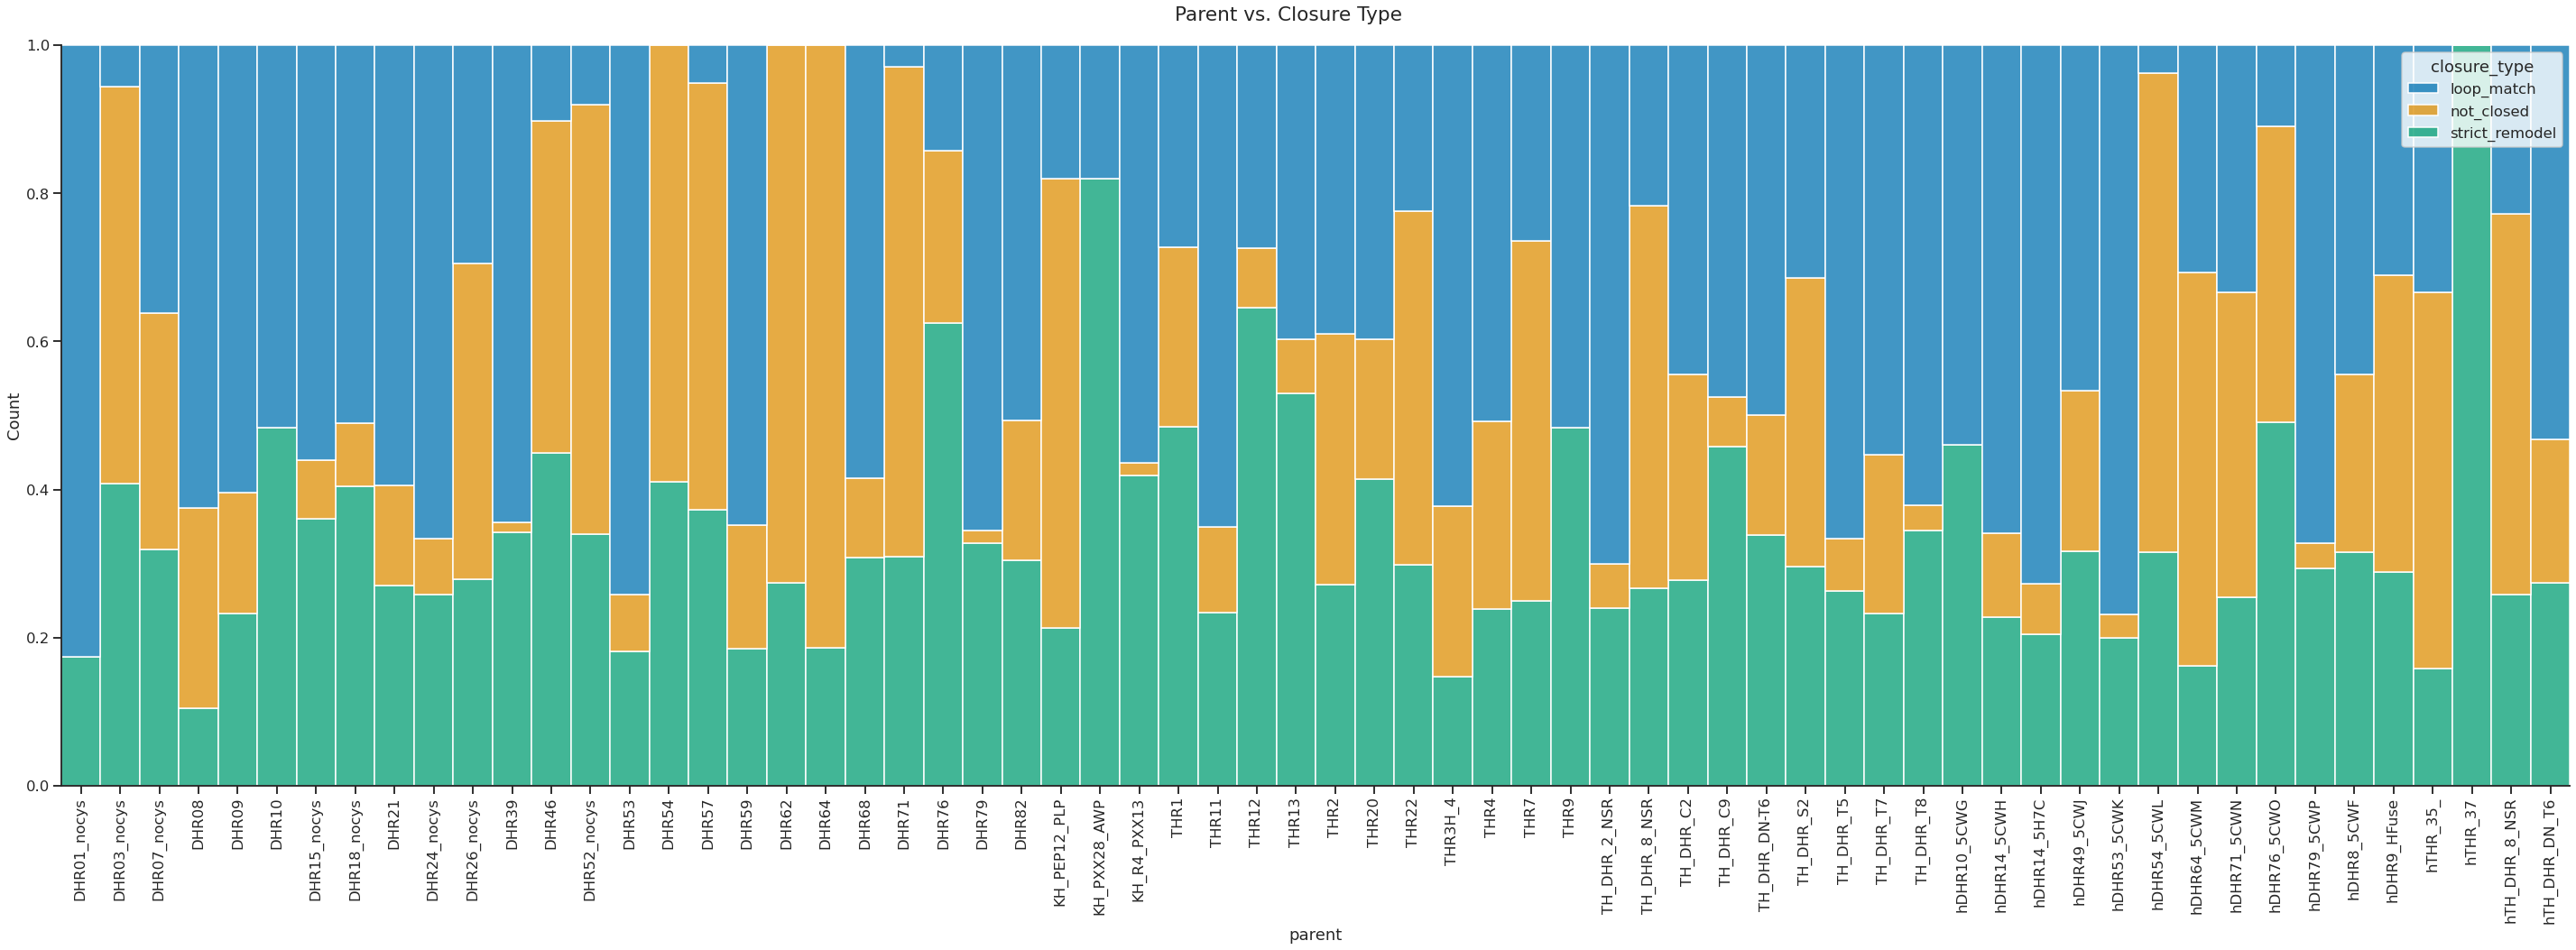

In [9]:
fig, ax = plt.subplots(ncols=1, figsize=(40, 15), tight_layout=True)

sns.histplot(
    x="parent",
    data=scores_df.sort_values(["parent"]),
    ax=ax,
    hue="closure_type",
    hue_order=hue_order,
    multiple="fill",
)
plt.xticks(rotation=90)
sns.despine()
plt.suptitle("Parent vs. Closure Type")
plt.savefig("figs/03_parent_groupby_closure.png")

### Some DHRs are very hard to close
Remodel improves the success rate by quite a bit
THRs and TH_DHRs varied a lot as well. Seems like helical phase matters a lot

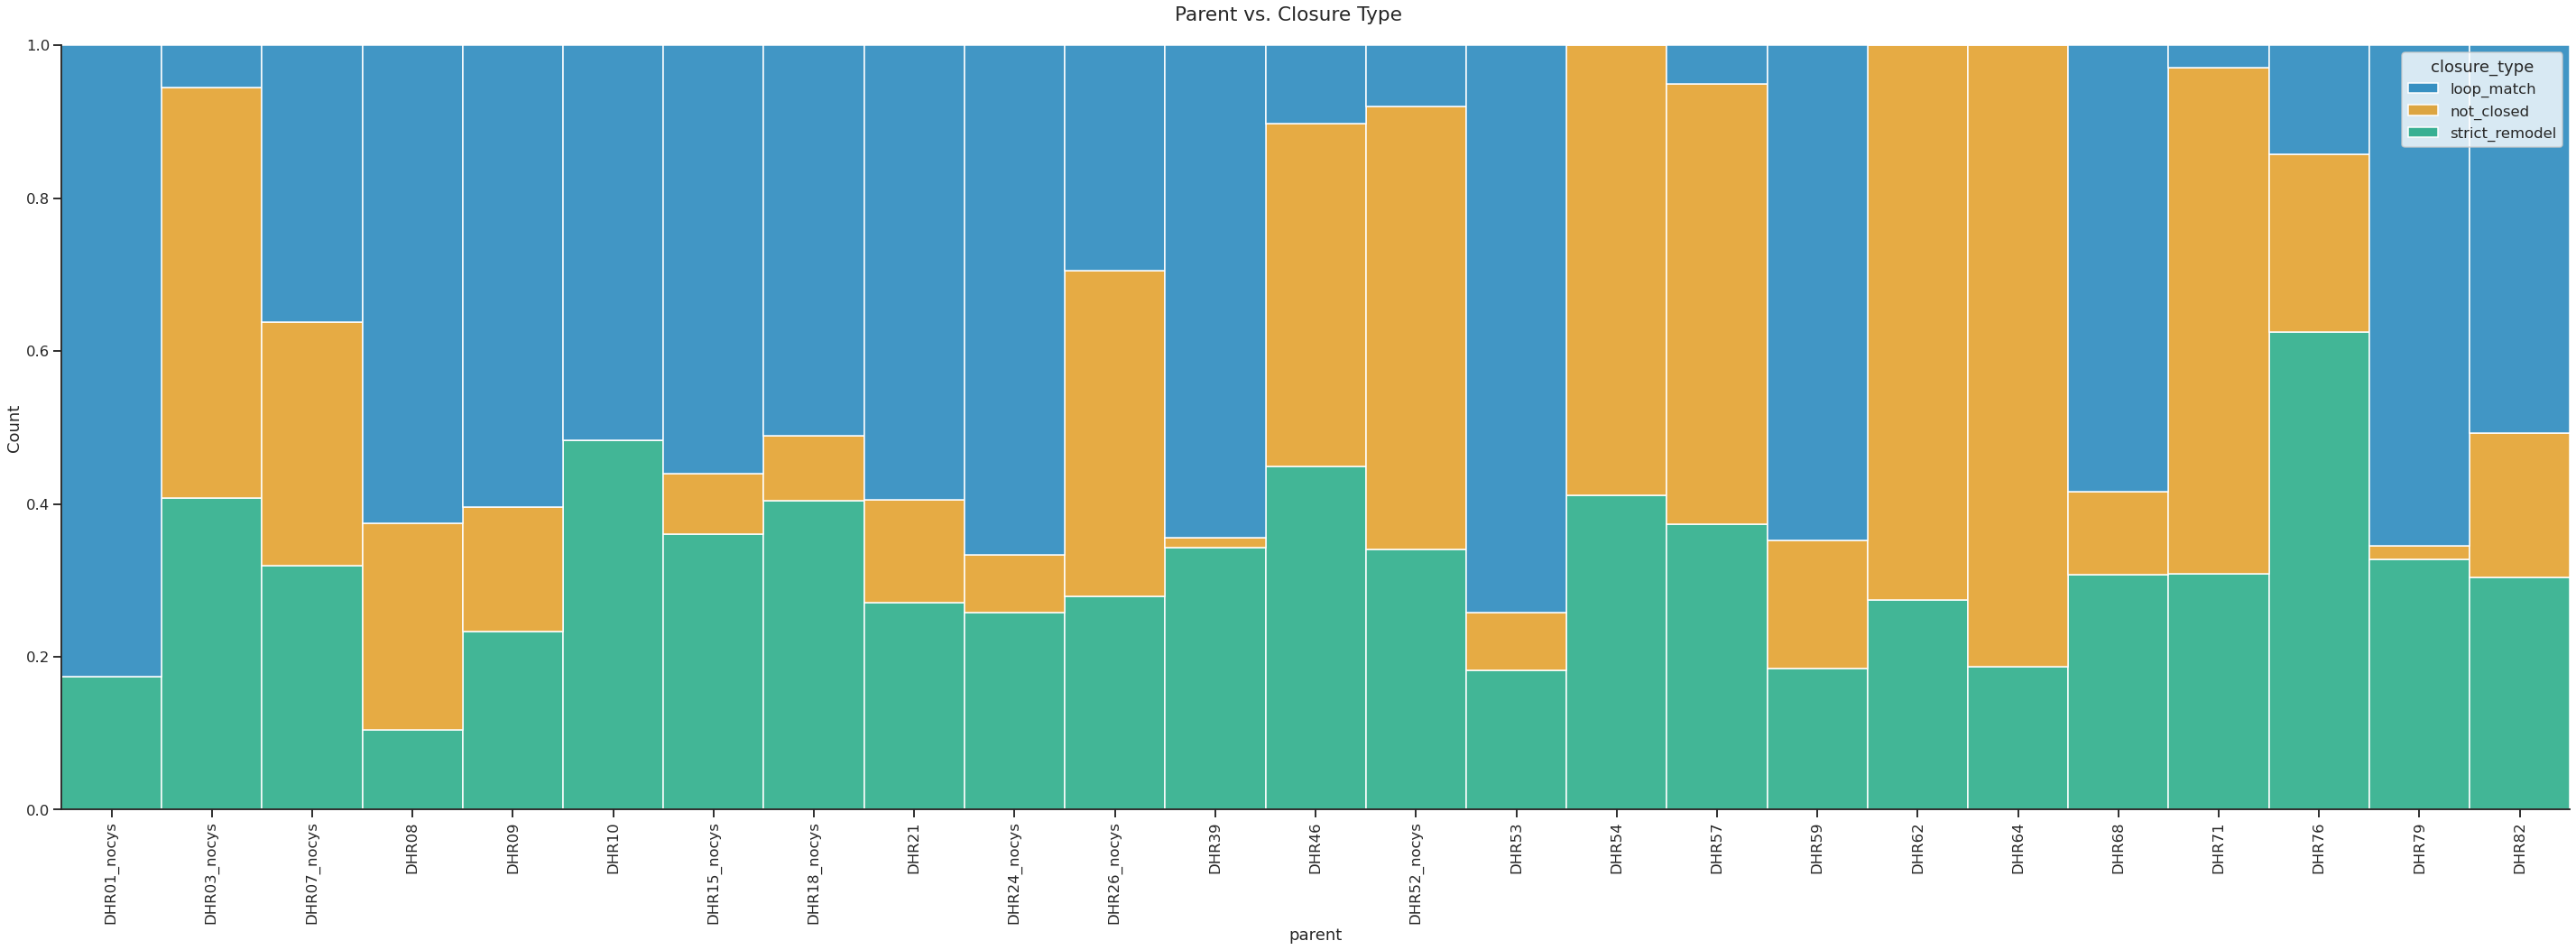

In [10]:
fig, ax = plt.subplots(ncols=1, figsize=(40, 15), tight_layout=True)

sns.histplot(
    x="parent",
    data=scores_df[scores_df["scaffold"] == "DHR"].sort_values(["parent"]),
    ax=ax,
    hue="closure_type",
    hue_order=hue_order,
    multiple="fill",
)
plt.xticks(rotation=90)
sns.despine()
plt.suptitle("Parent vs. Closure Type")
plt.savefig("figs/03_parent_DHRs_only_groupby_closure.png")

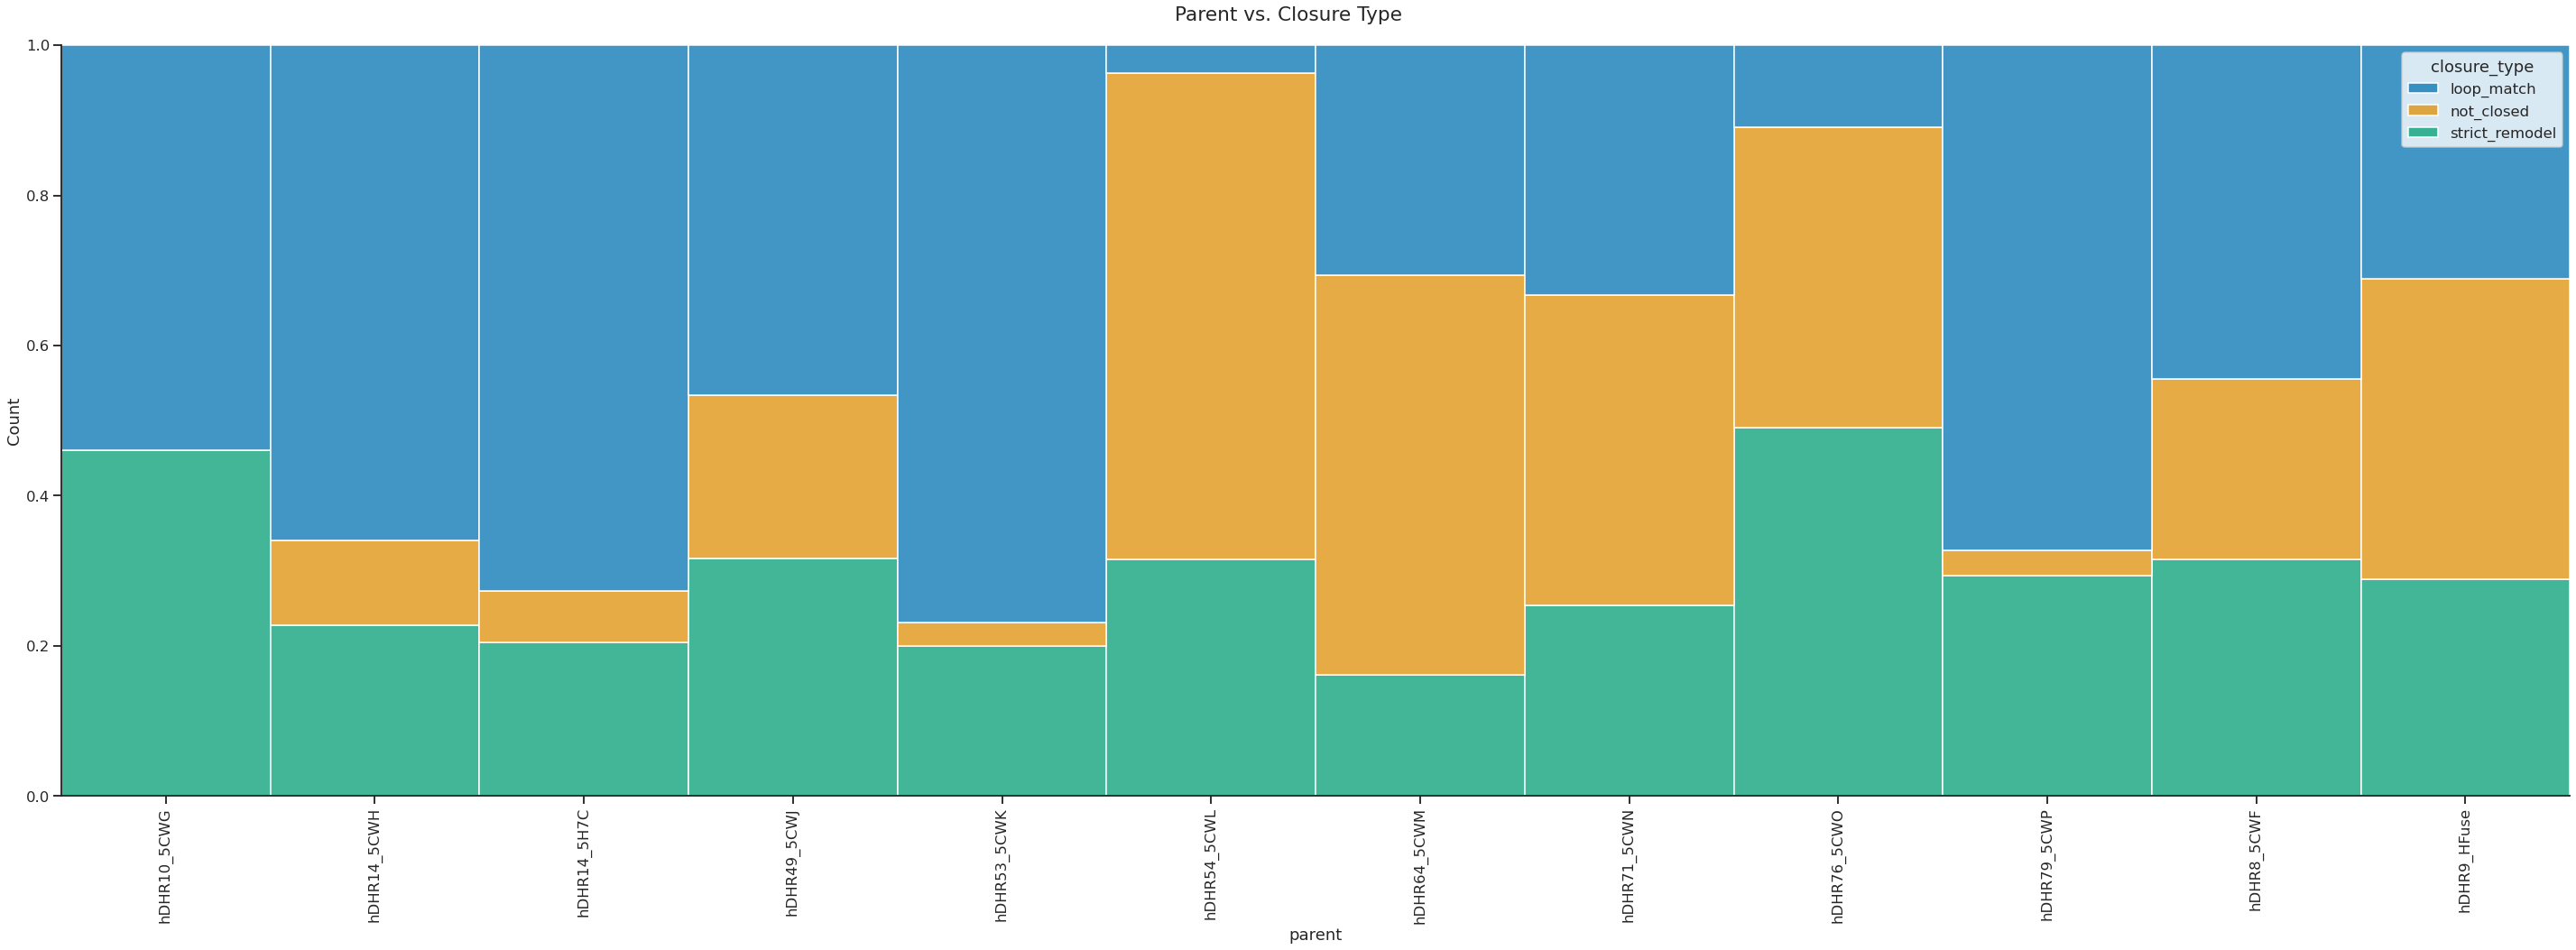

In [11]:
fig, ax = plt.subplots(ncols=1, figsize=(40, 15), tight_layout=True)

sns.histplot(
    x="parent",
    data=scores_df[scores_df["scaffold"] == "hDHR"].sort_values(["parent"]),
    ax=ax,
    hue="closure_type",
    hue_order=hue_order,
    multiple="fill",
)
plt.xticks(rotation=90)
sns.despine()
plt.suptitle("Parent vs. Closure Type")
plt.savefig("figs/03_parent_hDHRs_only_groupby_closure.png")

### Let's get all the ones that were able to be closed
Save a list of the closed designs

In [12]:
closed = scores_df[scores_df.closure_type != "not_closed"]
# the handful of designs that have a helical dssp in the loop need to be taken out too
closed = closed[closed.new_loop_resis != ""]
len(closed)

2758

In [13]:
out_path = os.path.join(os.getcwd(), "03_enumerate_loops")
with open(os.path.join(out_path, "closed.list"), "w+") as f:
    for decoy in closed.index:
        print(decoy, file=f)